<a href="https://colab.research.google.com/github/YasirHabib/Deep-Learning-Advanced-Computer-Vision/blob/master/style_transfer_III_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

In [0]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from scipy.optimize import fmin_l_bfgs_b

In [13]:
!pip install import-ipynb
import import_ipynb
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Copy the link and remove the front part of the link (i.e. https://drive.google.com/open?id=) to get the file ID.
your_module = drive.CreateFile({'id':'1OS3WuLk31e5jrMaw3pBT-2A8ZBEfpxX_'})
your_module.GetContentFile('style_transfer_keras.ipynb')
from style_transfer_keras import VGG16_AvgPool, unpreprocess, scale_img

your_module = drive.CreateFile({'id':'14QT9IUNGy3m_uAxBszK_WtKHbnn9um4P'})
your_module.GetContentFile('style_transfer_II_keras.ipynb')
from style_transfer_II_keras import gram_matrix, style_loss, minimize

In [14]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
def load_img_and_preprocess(path, shape=None):
  img = image.load_img(path, target_size=shape)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  return x

In [0]:
content_img = load_img_and_preprocess('/content/gdrive/My Drive/Colab Notebooks/Deep Learning: Advanced Computer Vision/image_0002.jpg')

In [0]:
# resize the style image
# since we don't care too much about warping it
h, w = content_img.shape[1:3]
style_img = load_img_and_preprocess('/content/gdrive/My Drive/Colab Notebooks/Deep Learning: Advanced Computer Vision/image_0003.jpg', (h, w))

iter=0, loss=3690.4619140625
iter=1, loss=1623.191650390625
iter=2, loss=771.3209838867188
iter=3, loss=459.60687255859375
iter=4, loss=373.7319641113281
iter=5, loss=330.60772705078125
iter=6, loss=297.78680419921875
iter=7, loss=274.1456298828125
iter=8, loss=251.95982360839844
iter=9, loss=234.07904052734375
iter=10, loss=223.4364013671875
iter=11, loss=214.23538208007812
iter=12, loss=206.77017211914062
iter=13, loss=198.9689483642578
iter=14, loss=192.8096923828125
iter=15, loss=185.8180694580078
iter=16, loss=180.64471435546875
iter=17, loss=175.62615966796875
iter=18, loss=171.69918823242188
iter=19, loss=168.4883270263672


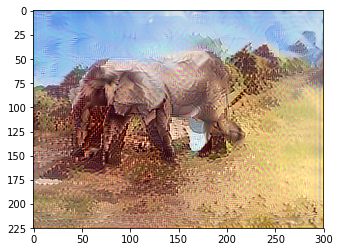

In [18]:
# we'll use this throughout the rest of the script
batch_shape = content_img.shape
shape = content_img.shape[1:]

# we want to make only 1 VGG here
# as you'll see later, the final model needs
# to have a common input
vgg = VGG16_AvgPool(shape)

# create the content model
# we only want 1 output
# remember you can call vgg.summary() to see a list of layers
content_model = Model(vgg.input, vgg.layers[13].get_output_at(0))                 # vgg.layers[13].get_output_at(0))  => (?, 14, 18, 512)
content_target = K.variable(content_model.predict(content_img))

# create the style model
# we want multiple outputs
# we will take the same approach as in style_transfer2.py
symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in vgg.layers \
  if layer.name.endswith('conv1')
]

# make a big model that outputs multiple layers' outputs
style_model = Model(vgg.input, symbolic_conv_outputs)

# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

# we will assume the weight of the content loss is 1
# and only weight the style losses
style_weights = [0.2,0.4,0.3,0.5,0.2]

# create the total loss which is the sum of content + style loss
loss = K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
  # gram_matrix() expects a (H, W, C) as input
  loss += w * style_loss(symbolic[0], actual[0])

# once again, create the gradients and loss + grads function
# note: it doesn't matter which model's input you use
# they are both pointing to the same keras Input layer in memory
grads = K.gradients(loss, vgg.input)

# just like theano.function
get_loss_and_grads = K.function(
  inputs=[vgg.input],
  outputs=[loss] + grads
)

def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)


final_img = minimize(get_loss_and_grads_wrapper, 20, batch_shape)
plt.imshow(scale_img(final_img))
plt.show()